In [1]:
from joblib import load
import os
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import useful_functions as uf
import pandas as pd
import coin_circle_detector as ccd

# Cargar el modelo guardado
modelo_cargado = load('modelo_random_forest.joblib')


In [3]:
def image_result(img, circulos, labels, save=False, img_name = None):
    total = sum(map(float, labels))
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = .7
    color = (0, 0, 0)
    thickness = 2
    img_ = img.copy()
    for n, i in enumerate(circulos):
        cv2.circle(img_, (i[0], i[1]), i[2], (0, 0, 0), 1)
        cv2.putText(img_, labels[n], (i[0]-int(i[2]*0.6),i[1]), font, 
                    fontScale, color, thickness, cv2.LINE_AA)
        
    img_ = uf.imagen_con_texto(img_, f'{total:.2f} euros', posicion= [[0, 0], [.45, .2]])

    f, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cv2.cvtColor(img_, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    if save: f.savefig(f'results/result_{img_name}')
    plt.show()


In [4]:
folder = 'data'

images = [f for f in os.listdir(folder) if f.endswith('.jpg')]
img_files_filter = list(filter(lambda x: 'test' in x, images))
uf.sort_list_of_fs_by_ascending_number(img_files_filter, r_pattern='image_')

print(f'se va a testear con {len(img_files_filter)} imagenes ')

se va a testear con 21 imagenes 


In [5]:
if os.path.exists('results'):
    _ = [os.remove(f'results/{f}') for f in os.listdir('results')]
else:
    os.makedirs('results')
    print("carpeta 'results' creada")
    

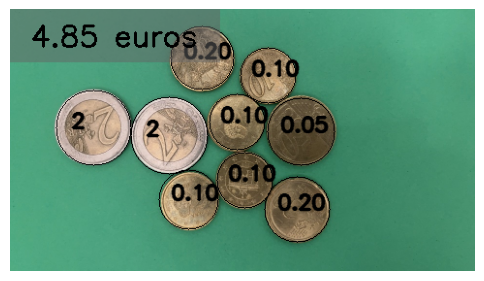

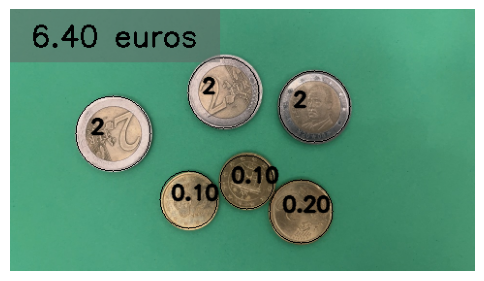

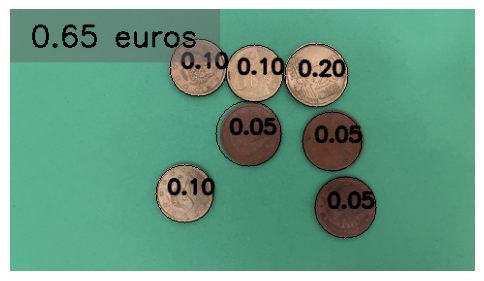

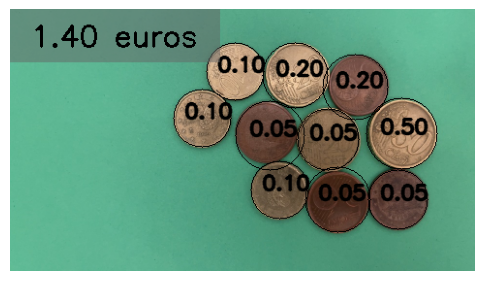

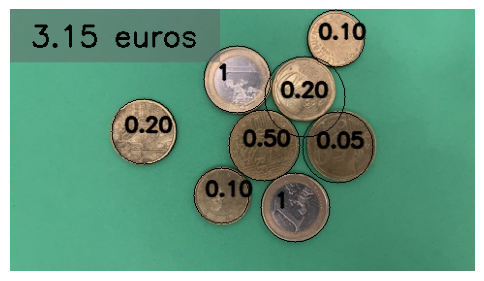

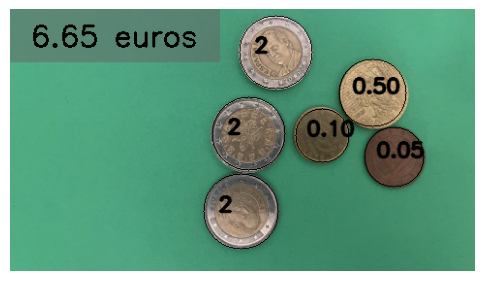

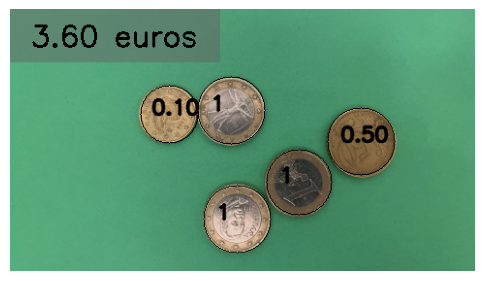

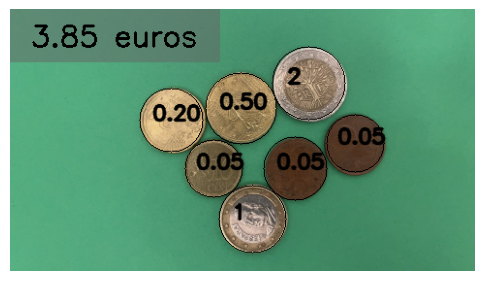

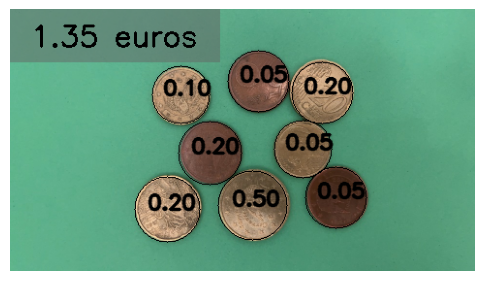

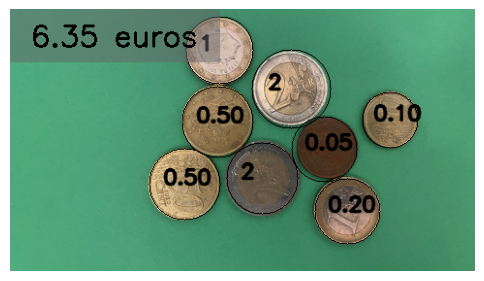

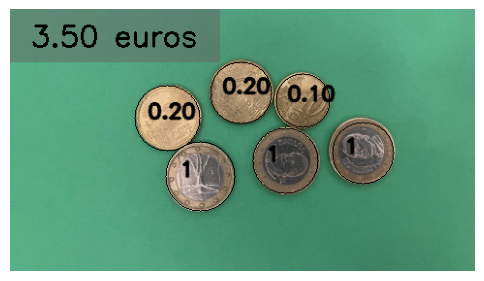

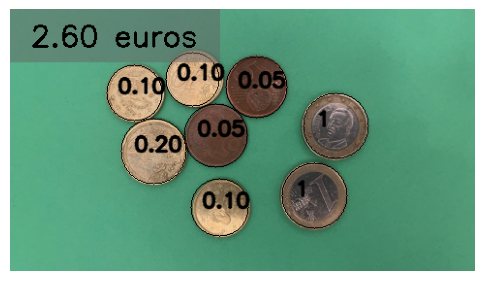

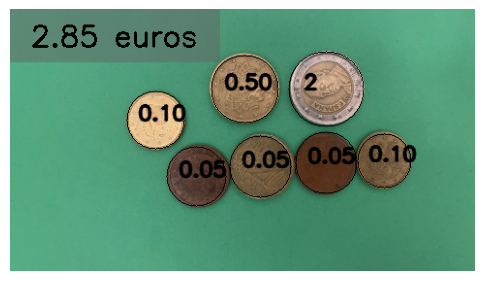

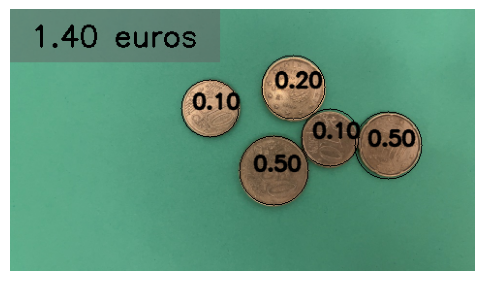

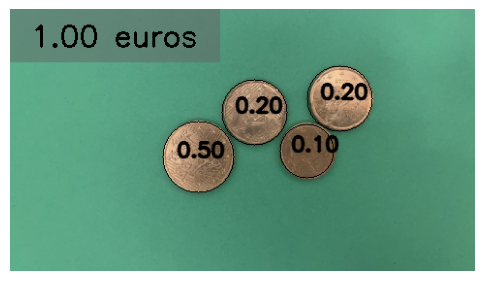

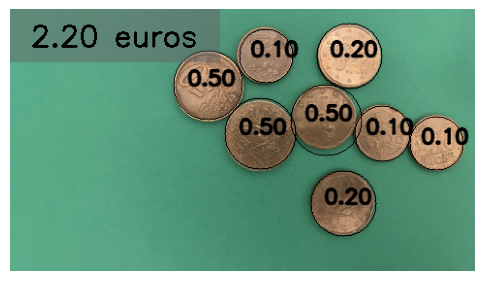

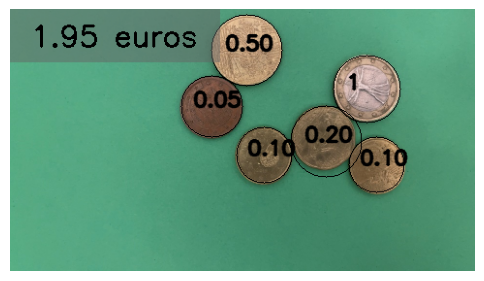

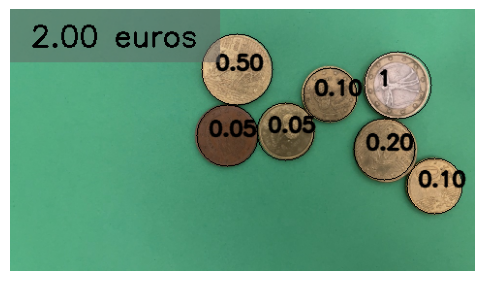

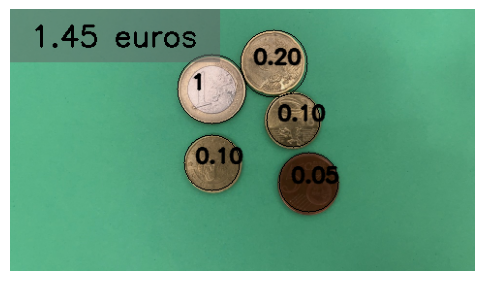

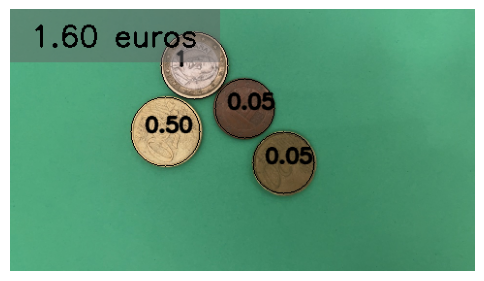

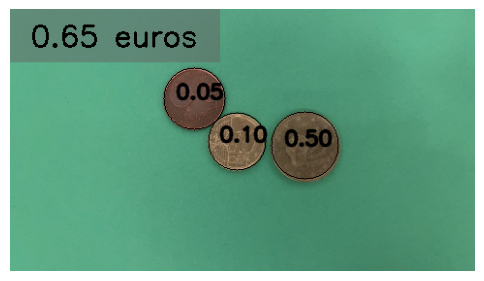

In [8]:
grosor = 1

for img_n in img_files_filter:
    monedas = ['0.05', '0.10', '0.20', '0.50', '1', '2']
    _, _, circulos  = ccd.coins_detec_alg(f'{folder}/{img_n}', params={'dp':.5, 'param2':11}, vis_result=False)
    ################
    colores_monedas = {}
    
    colores = []
    hues_aros = []

    img = cv2.imread(f'{folder}/{img_n}')
    imgPre = ccd.image_prepros(img)

    if circulos is not None:
        radio_values_df = pd.DataFrame({'radio': circulos[:,2]})
        for cir in circulos:
                imgPre_ = imgPre.copy()
                color = uf.get_color_from_circle(imgPre_, cir[:2], cir[2], vis= False)
                valor_h = cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_BGR2HSV)[0][0][0]
                valor_s = cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_BGR2HSV)[0][0][1]
                valor_v = cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_BGR2HSV)[0][0][2]
                colores.append([valor_h, valor_s, valor_v])
                
                hue_medio_1 = uf.hue_promedio_anillo(imgPre, cir[0], cir[1], int(cir[2]-cir[2]*0.05), grosor, visualizar=False)
                hue_medio_1 = int(hue_medio_1.mode[0])
                
                hue_medio_2 = uf.hue_promedio_anillo(imgPre, cir[0], cir[1], int(cir[2]-cir[2]*0.7), grosor, visualizar=False)
                hue_medio_2 = int(hue_medio_2.mode[0])
                hues_aros.append(abs(hue_medio_1 - hue_medio_2))

        hues_aros_df = pd.DataFrame({'hue_values': hues_aros})
        colores_df = pd.DataFrame(colores, columns=['h','s','v'])
        image_data = pd.concat([colores_df, hues_aros_df, radio_values_df], axis=1)
        ################
        predicciones = modelo_cargado.predict(image_data)
        labels = [monedas[i] for i in predicciones]
        img_ = cv2.resize(img, None, fx = .5, fy=.5)
        image_result(img_, circulos, labels) # True, img_n
